One may think that any numeric data is ready to be the input of a model, but that's not true.

Some common operations involve:
- Centering and Scaling
- Dealing With Skewed Data
- Highly Correlated Variables
- Imputing

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
sns.set_style("whitegrid")
# # Bigger font
sns.set_context("talk")
# # Figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 4
np.random.seed(123)

## 1. Data Transformations

**Transformation** = Application of a deterministic mathematical function to each point in the data.

**Monotonic transformation** = Application of a monotonic function that is either entirely nonincreasing or nondecreasing. A function is monotonic if its first derivative (which need not be continuous) does not change sign.

**Monotonically increasing** = When for all $x$ and $y$ such that $x\leq y$, one has $f(x)\leq f(y)$, so $f$ **preserves the order**.

**log–log graph or log–log plot** = A two-dimensional graph of numerical data that uses logarithmic scales on both the horizontal and vertical axes (this may have nothing to do with this, but I heard some people suggesting this when talking about transformations).

When data are very strongly **skewed**, we sometimes transform them so they become **normally distributed** because they are easier to model and **outliers** become less extreme.

The most common transformations are **Log** where $c$ is a constant so that we don't have $\log(0)$.

$$ x_{new} = \log(x + c)$$

or **Square root**

$$ x_{new} = \sqrt{x}$$

The (Natural) Log transformation is the most common and can be used for a main purpose.

### a. To make a distribution symmetric

- It is applied when much of the data cluster near 0, and all observations are positive.
- It turns **skewed** data into symmetric.

Text(0.5,1,'sqrt')

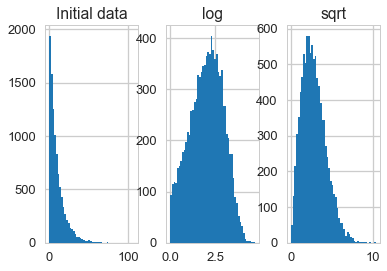

In [2]:
np.random.seed(100)

fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
skewed = np.random.exponential(scale=10,
                               size= 10000)
skewed = pd.DataFrame(skewed)
skewed.hist(bins=50, ax=ax)
ax.set_title("Initial data")

ax = fig.add_subplot(1, 3, 2)
log_transformed = (skewed + 1).apply(np.log)
log_transformed.hist(bins=50, ax=ax)
ax.set_title("log")

ax = fig.add_subplot(1, 3, 3)
sqrt_transformed = skewed.apply(np.sqrt)
sqrt_transformed.hist(bins=50, ax=ax)
ax.set_title("sqrt")

### b. To make a linear relationship between 2 variables

- It can be applied to one or both variables in a scatterplot to make their **relationship more linear**.

![](images/transform1.png)

![](images/transform2.png)

### c. To improve the interpretability or appearance of graphs

This seems obvious because by doing a log transformation, the highest values become lower (this makes outliers disappear).

## 2. Highly Correlated Variables or Multicollinearity

You want each feature to always tell you something different. Variables with strong correlations can interfere with one another.

**Collinearity:** A strong correlation or tendency to move together, typically due to some underlying similarity or common influencing factor.

Correlation is related to collinearity. If 2 variables are highly correlated, then they are probably collinear.

- Many features make a model harder to understand.
- Non-tree-based models are sensitive to multicollinearity.

### Tree-based models

- Tree-based model, SVM, and Ridge regression aren't sensitive to multicollinearity.

### Non-tree-based models

- **Combine** correlated variables in some way.
- **Remove** correlated variables.
- Do **dimensionality reduction** like Partial Least Squares Regression (PLS) or Principal Components Analysis (PCA). They are methods that cut the number of features to a smaller set of uncorrelated components.

In this dataset, the thing is to predict "mpg", gas mileage.

In [5]:
from plotnine import *
from plotnine.data import *
if "name" in mtcars.columns:
    mtcars.index = mtcars.name
    del mtcars["name"]
df = mtcars
print(df.shape)

(32, 11)


These are ways to check multicollinearity.

### a. Pairplot

- This shows the relationships between pairs of variables.
- It can also help identify oddities in the data such as variables like **"cyl" that only take on values in a small discrete set**.

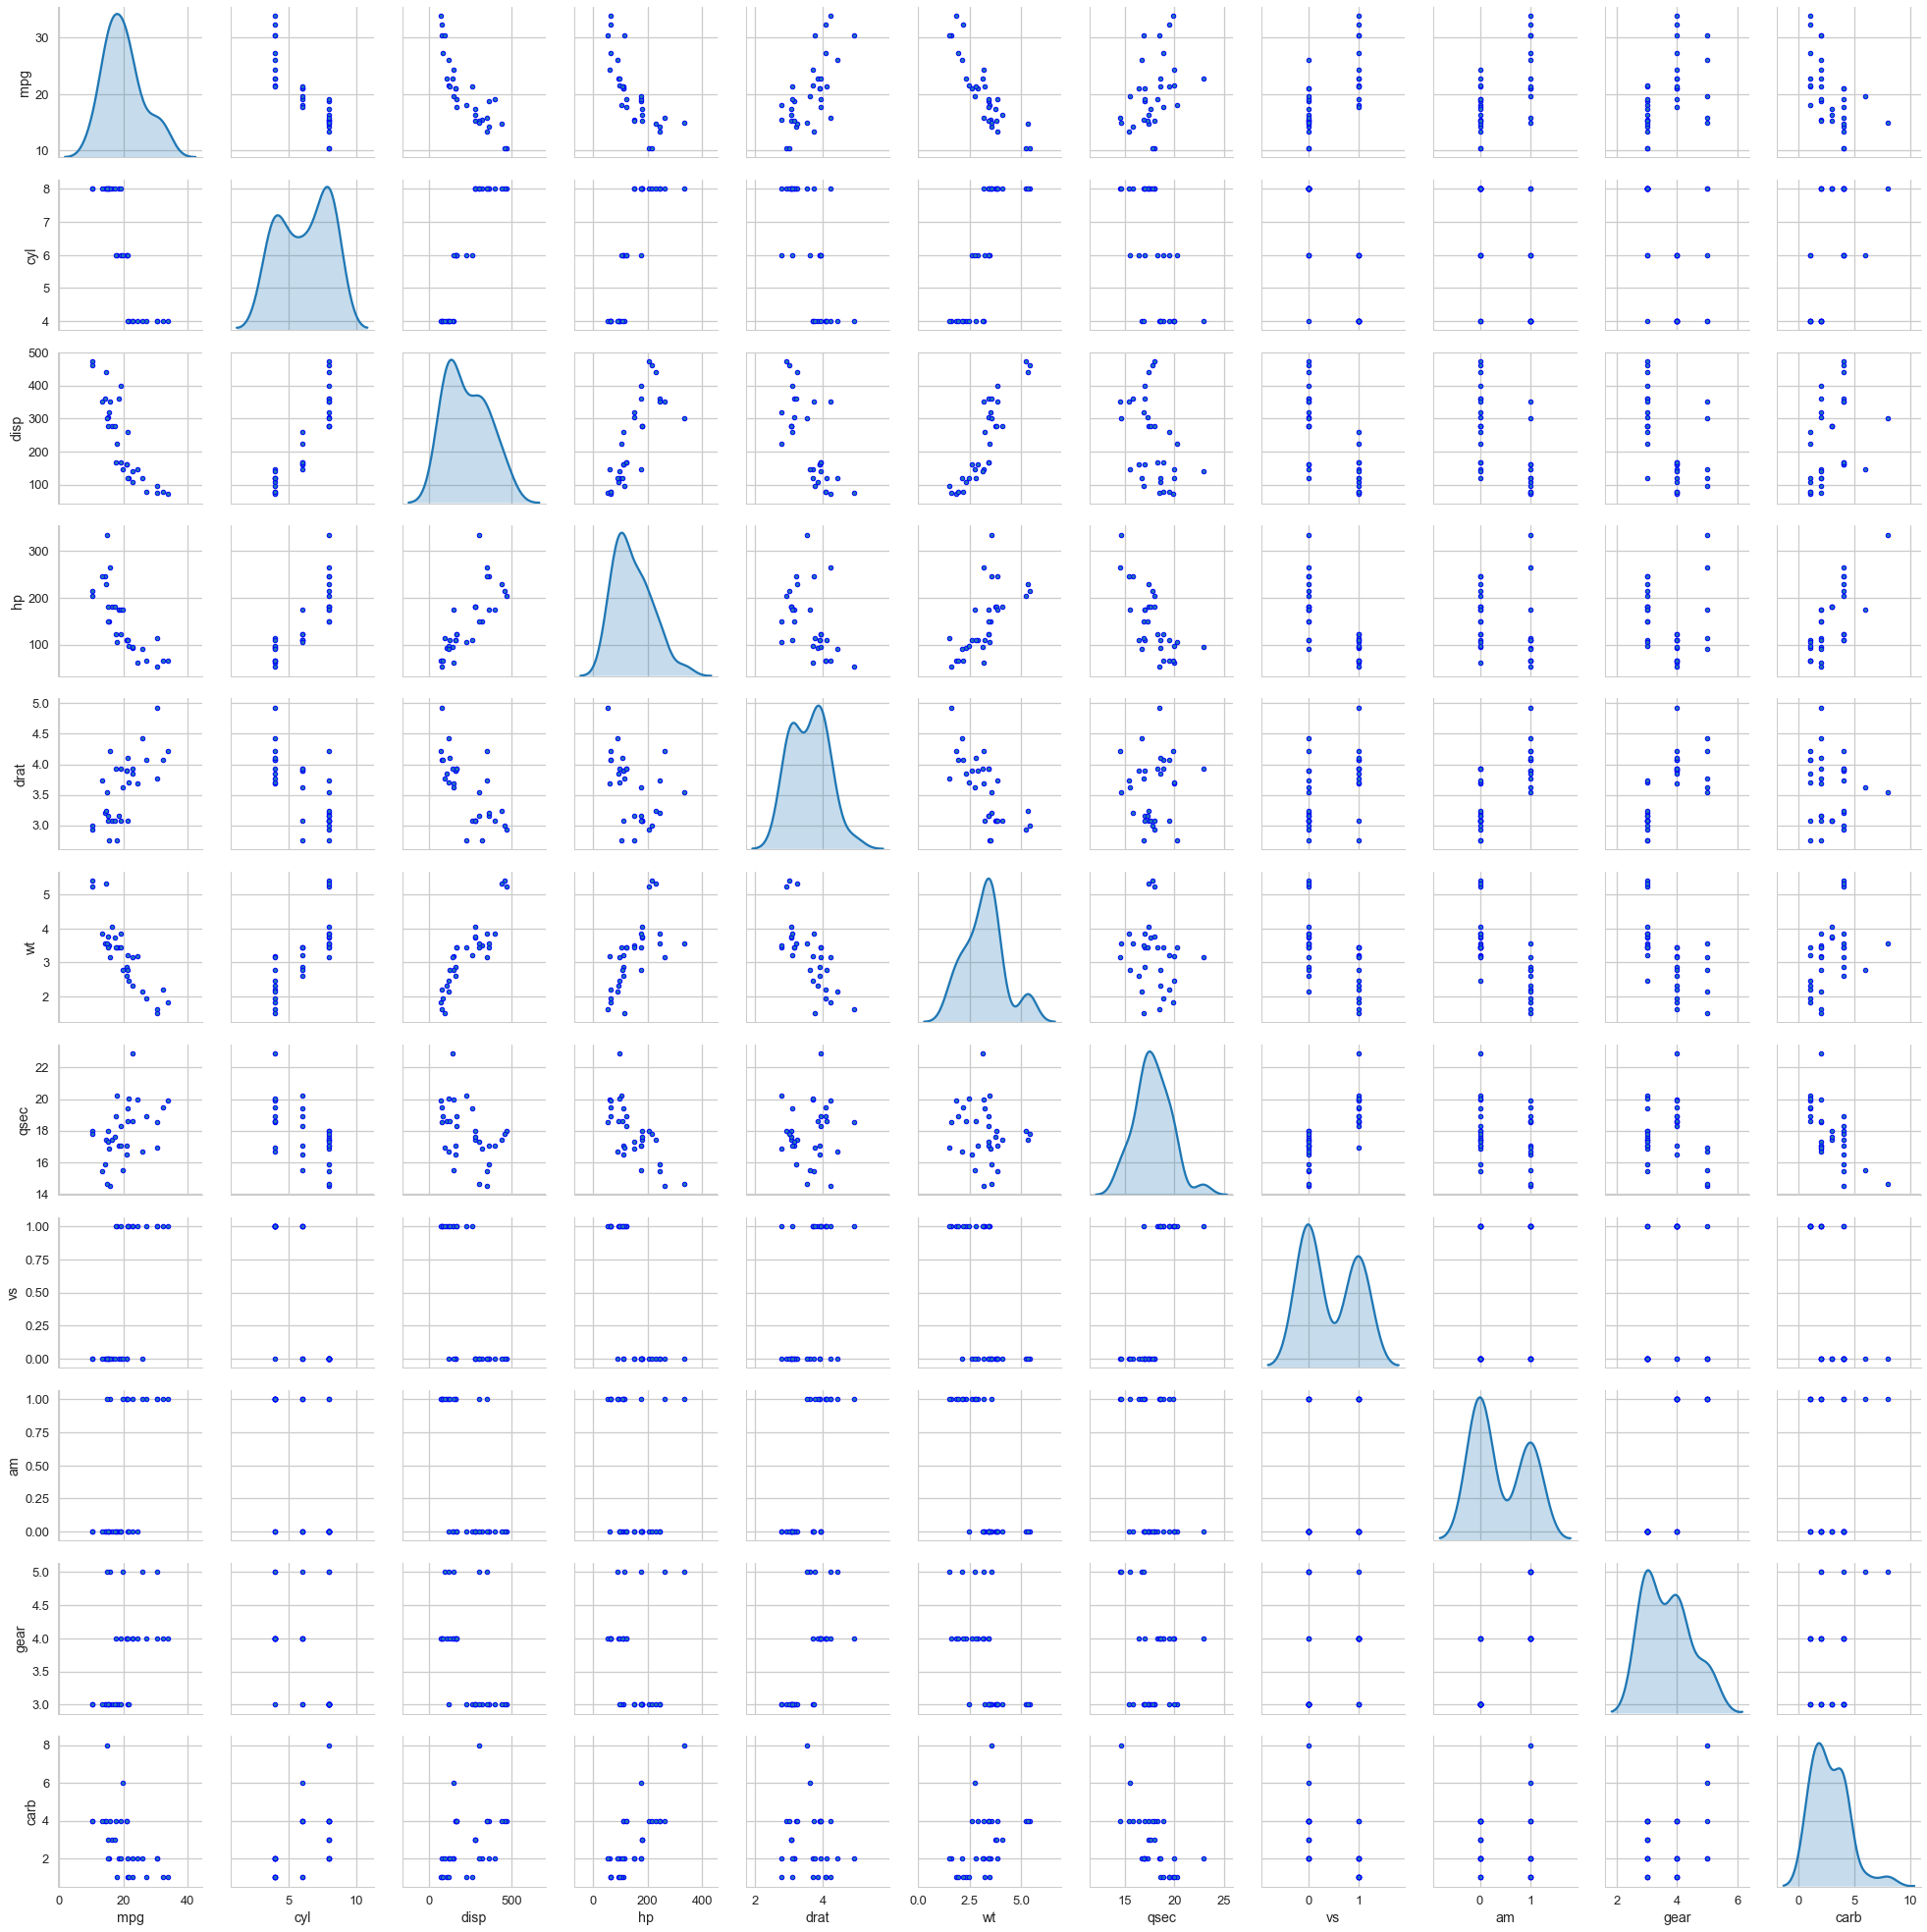

In [6]:
sns.pairplot(df,
            diag_kind="kde",
            plot_kws=dict(s=20, edgecolor="b", linewidth=1),
            diag_kws=dict(shade=True))

This will only show the first row

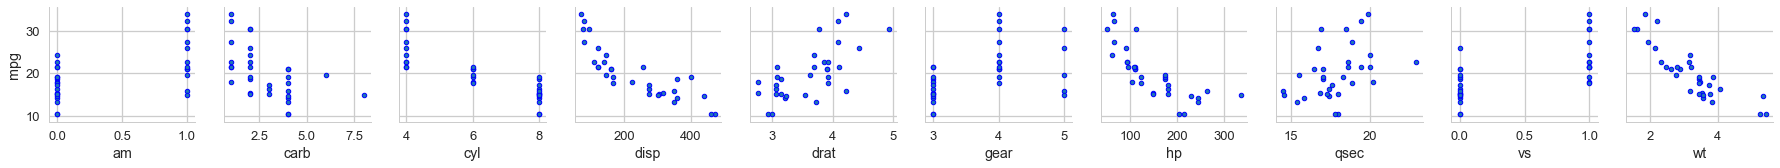

In [7]:
sns.pairplot(df,
            y_vars=['mpg'],
            x_vars=df.columns.difference(['mpg']),
            plot_kws=dict(s=20, edgecolor="b", linewidth=1),
            diag_kws=dict(shade=True))

### b. Pairwise correlations

This is the pairwise correlations between variables.

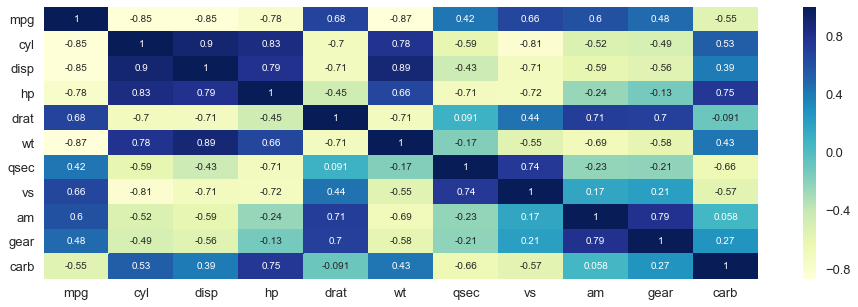

In [8]:
corr = df.corr()
# plot the heatmap
plt.figure(figsize = (16,5))
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True, cmap="YlGnBu")

**"cyl" and "disp" are strongly correlated**, so one may think of removing one of them.

### c. Variance Inflation Factor (VIF)

This is used to detect multicollinearity in regression analysis.

$$VIF_i = \frac{1}{1-R_i^2}$$

- The VIF estimates how much the variance of a regression coefficient is inflated due to multicollinearity in the model $Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_k X_k$
- VIF ranges from 1 upwards. It tells what percentage the variance is inflated for each coefficient.

A VIF of 1 means that there is no correlation among the i-th variable and the remaining variables, and hence the variance of $\beta_i$ is not inflated at all. The general rule of thumb is that VIFs exceeding 4 warrant further investigation, while VIFs exceeding 10 are signs of serious multicollinearity requiring correction.

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
features = "+".join(df.columns.difference(['mpg']))
y, X = dmatrices('mpg ~' + features, df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,1596.273030,Intercept
1,4.648487,am
2,7.908747,carb
3,15.373833,cyl
4,21.620241,disp
5,3.374620,drat
6,5.357452,gear
7,9.832037,hp
8,7.527958,qsec
9,4.965873,vs


Having an intercept $\beta_0 = 1$, this tells us that there is high correlation between **"disp"** and the other variables.

However, this is only useful when we are training a linear model, and it is part of linear regression analysis. https://rpubs.com/davoodastaraky/mtRegression